# Wave equation with dispersion

In [1]:
import numpy as np
import scipy as sp
import scipy.integrate
import matplotlib.pyplot as plt
from matplotlib import animation
import matplotlib
from IPython.display import HTML
plt.rcParams['animation.html'] = 'html5'

Domain and initial condition function:

In [2]:
T = np.arange(100)/10
L = 4*np.pi
X = np.linspace(0, L, 80, endpoint=False)

In [3]:
def f(x):
    #return (1 + np.sin(x))**2
    #return np.sin(x)
    return np.cos(2*x)**2 * ((x>7*L/16) & (x<9*L/16))

Initial conditions for ode solver:

In [4]:
xi = np.fft.fftfreq(len(X))*(len(X))*2*np.pi /(X[-1] - X[0])
u0 = np.fft.fft(f(X))
#v0 = -1.j*xi*u0
v0 = np.zeros_like(u0, dtype='complex')
w0 = np.zeros_like(u0, dtype='complex')
q0 = np.zeros_like(u0, dtype='complex')

Derivative function for equation:
$$ u_{tt} - u_{xx} + \delta^2[d_2 (u_{tttt} + u_{xxxx}) - d_1 u_{xxtt}] = 0 $$

In [5]:
delta = 0.001
d1 = 3
d2 = 1

def der(t, y):
    u, v = y.reshape(2, -1)
    du = v
    dv = -xi**2 * (1 - delta**2*d2*xi**2) / (1 + delta**2*d1*xi**2) * u
    return np.concatenate((du, dv))

def der4(t, y):
    u, v, w, q = y.reshape(4, -1)
    du = v
    dv = w
    dw = q
    dq = -1/d2*((d1*xi**2 + 1/delta**2)*w + xi**2*(d2*xi**2 + 1/delta**2)*u)
    return np.concatenate((du, dv, dw, dq))

Solve and plot

In [6]:
# Numerical ode solution
U, V = [], []
r = sp.integrate.complex_ode(der4).set_integrator('dop853', rtol=1e-10, atol=1e-10, nsteps=1e4)
r.set_initial_value(np.concatenate((u0, v0, w0, q0)))
for t in T:
    if t > 0:
        r.integrate(t)
    u, v, w, q = r.y.reshape(4, -1)
    U.append(np.fft.ifft(u).real)
    #V.append(np.fft.ifft(v).real)

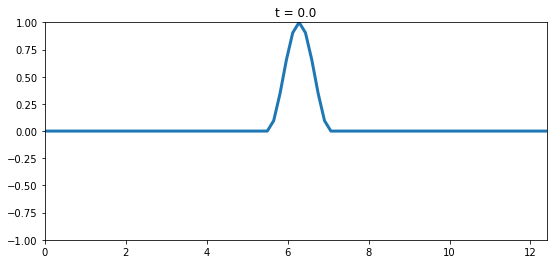

In [7]:
fig = plt.figure(figsize=(9,4))
axes = fig.add_subplot(111)
line, = axes.plot([],[],lw=3)
axes.set_xlim(X[0], X[-1]) 
axes.set_ylim(-1,1)

def plot_frame(i):
    line.set_data(X, U[i])
    axes.set_title('t = ' + str(T[i]))
    fig.canvas.draw()
    return fig

# Animate the solution
matplotlib.animation.FuncAnimation(fig, plot_frame, frames=len(U),
                                   interval=100, repeat=False)